# Test simulating compendia by random sampling

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import random
import umap
import tensorflow as tf
from plotnine import (ggplot,
                      labs,  
                      geom_point,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)


import warnings
warnings.filterwarnings(action='ignore')

from ponyo import utils, train_vae_modules, simulate_expression_data

Using TensorFlow backend.


In [2]:
# Set seeds to get reproducible VAE trained models

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

os.environ["PYTHONHASHSEED"] = "0"

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
random.seed(12345)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
tf.set_random_seed(1234)

In [3]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))
config_file = os.path.abspath(os.path.join(base_dir,
                                           "human_tests", 
                                           "config_test_human.tsv"))
params = utils.read_config(config_file)

In [4]:
# Load parameters
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
analysis_name = params["simulation_type"]
train_architecture = params['NN_architecture']
num_simulated_samples = params['num_simulated_samples']

In [5]:
# Input files
rpkm_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "recount2_gene_RPKM_data_test.tsv")
assert os.path.exists(rpkm_data_file)

## Setup directories

In [6]:
utils.setup_dir(config_file)

In [7]:
# Check that directories were made correctly
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'logs'))
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'models'))
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'results'))
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'logs', train_architecture))
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'models', train_architecture))
assert os.path.isdir(os.path.join(base_dir, dataset_name, 'results', 'saved_variables'))

## Pre-process data

In [8]:
# Output file
normalized_data_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "input",
    "recount2_gene_normalized_data_test.tsv.xz")

In [9]:
train_vae_modules.normalize_expression_data(base_dir,
                                            config_file,
                                            rpkm_data_file,
                                            normalized_data_file)

input: dataset contains 50 samples and 5000 genes
Output: normalized dataset contains 50 samples and 5000 genes


## Train VAE

In [10]:
# Directory containing log information from VAE training
vae_log_dir = os.path.join(
    base_dir, 
    dataset_name,
    "logs",
    train_architecture)

input dataset contains 50 samples and 5000 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 45 samples, validate on 5 samples
Epoch 1/10
45/45 [==============================] - 4s 93ms/step - loss: 2511.2365 - val_loss: 2078.2676
Epoch 2/10
45/45 [==============================] - 4s 93ms/step - loss: 1688.8236 - val_loss: 2374.3589
Epoch 3/10
45/45 [==============================] - 4s 85ms/step - loss: 1664.0755 - val_loss: 1454.6667
Epoch 4/10
45/45 [==============================] - 4s 85ms/step - loss: 1509.4538 - val_loss: 1387.5260
Epoch 5/10
45/45 [==============================] - 4s 89ms/step - loss: 1474.1985 - val_loss: 1371.2039
Epoch 6/10
45/45 [==============================] - 4s 87ms/step - loss: 1489.1452 - val_loss: 1350.6823
Epoch 7/10
45/45 [====================

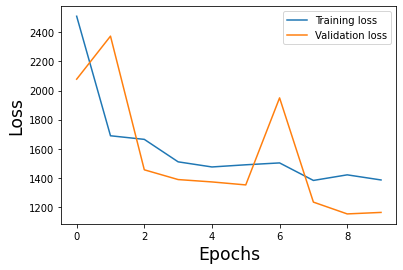

In [11]:
# Train VAE
train_vae_modules.train_vae(config_file,
                            normalized_data_file)

In [12]:
# Check reproducibility of VAE training
template_path = "data/test_vae_log.tsv"
output_path = "logs/NN_2500_30/tybalt_2layer_30latent_stats.tsv"
assert pd.read_csv(output_path, sep="\t")["val_loss"].values[-1] < 1500, pd.read_csv(output_path, sep="\t")["val_loss"].values[-1]

## Simulate data by random sampling

In [13]:
# Run simulation
simulated_data = simulate_expression_data.simulate_by_random_sampling(
    normalized_data_file,
    train_architecture,
    dataset_name,
    analysis_name,
    num_simulated_samples,
    local_dir,
    base_dir,
)

Normalized gene expression data contains 50 samples and 5000 genes
Return: simulated gene expression data containing 100 samples and 5000 genes


In [14]:
simulated_data.head()

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.114182,0.149590,0.187353,0.153791,0.114184,0.081041,0.191324,0.165688,0.020913,0.054697,...,0.233179,0.149026,0.057933,0.066153,0.094109,0.163646,0.050708,0.164401,0.108430,0.073048
1,0.667152,0.051712,0.097690,0.089152,0.055190,0.106053,0.409768,0.632928,0.009757,0.024046,...,0.080053,0.184228,0.020110,0.142014,0.026004,0.047421,0.063812,0.239064,0.548883,0.015507
2,0.640055,0.022509,0.048666,0.042211,0.033088,0.057906,0.401687,0.623414,0.003018,0.007428,...,0.057861,0.136663,0.007467,0.054277,0.007356,0.016772,0.019473,0.155120,0.506057,0.003954
3,0.216286,0.200629,0.162104,0.175291,0.142367,0.183066,0.238976,0.233668,0.043301,0.079027,...,0.223531,0.264715,0.060984,0.124557,0.100030,0.162706,0.085251,0.281522,0.144276,0.062041
4,0.377727,0.052962,0.118572,0.127285,0.057746,0.086458,0.229618,0.336233,0.010145,0.019144,...,0.088012,0.140088,0.027421,0.062928,0.040990,0.059350,0.037888,0.180633,0.319003,0.022663


## Visualize random sampled compendium

In [15]:
# Read data
normalized_data = pd.read_csv(normalized_data_file, header=0, sep="\t", index_col=0)

In [16]:
normalized_data.head()

,ENSG00000086200.16,ENSG00000279019.1,ENSG00000206772.1,ENSG00000252996.1,ENSG00000277635.1,ENSG00000224790.2,ENSG00000106636.7,ENSG00000152443.12,ENSG00000225819.1,ENSG00000237377.2,...,ENSG00000281392.1,ENSG00000241627.3,ENSG00000239216.1,ENSG00000256797.1,ENSG00000221263.1,ENSG00000249478.1,ENSG00000283340.1,ENSG00000242052.1,ENSG00000264443.1,ENSG00000236858.1
SRR592745,0.080978,0.886399,0.0,0.000654,0.676113,0.092019,0.563159,0.626964,0.0,0.000000,...,0.237537,0.241719,0.0,0.000000,0.0,0.000000,0.0,0.308343,0.111808,0.025641
SRR592746,0.087339,0.161515,0.0,0.000000,1.000000,0.053521,0.386222,0.333747,0.0,0.000000,...,0.114370,0.334752,0.0,0.000000,0.0,0.000000,0.0,0.124547,0.166928,0.000000
SRR592747,0.131139,0.411128,0.0,0.000000,0.000000,0.138028,0.514365,0.629170,0.0,0.000000,...,0.064516,0.514277,0.0,0.326923,0.0,0.000000,0.0,0.267231,0.149227,0.000000
SRR592748,0.144581,0.241113,0.0,0.044672,0.000000,0.135211,0.597027,0.866832,0.0,0.237624,...,1.000000,0.547814,0.0,0.000000,0.0,0.009901,0.0,0.637243,0.255882,0.041026
SRR592749,0.202282,0.047913,0.0,0.000000,0.000000,0.090141,0.667133,0.773918,0.0,0.000000,...,0.850440,0.486658,0.0,0.000000,0.0,0.014851,0.0,0.712213,0.230114,0.000000


In [17]:
model = umap.UMAP(random_state=123).fit(normalized_data)

input_data_UMAPencoded = model.transform(normalized_data)
input_data_UMAPencoded_df = pd.DataFrame(data=input_data_UMAPencoded,
                                         index=normalized_data.index,
                                         columns=['1','2'])

In [18]:
# UMAP embedding of simulated data

simulated_data_UMAPencoded = model.transform(simulated_data)
simulated_data_UMAPencoded_df = pd.DataFrame(data=simulated_data_UMAPencoded,
                                         index=simulated_data.index,
                                         columns=['1','2'])

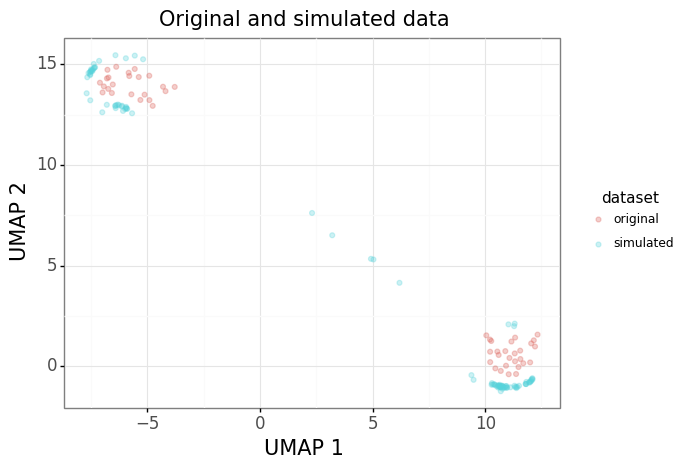

<ggplot: (8743330794613)>


In [19]:
# Overlay original input vs simulated data

# Add label for input or simulated dataset
input_data_UMAPencoded_df['dataset'] = 'original'
simulated_data_UMAPencoded_df['dataset'] = 'simulated'

# Concatenate input and simulated dataframes together
combined_data_df = pd.concat([input_data_UMAPencoded_df, simulated_data_UMAPencoded_df])

# Plot
g_input_sim = ggplot(combined_data_df, aes(x='1', y='2'))
g_input_sim += geom_point(aes(color='dataset'),alpha=0.3)
g_input_sim += labs(x = "UMAP 1",
                    y = "UMAP 2", 
                    title = "Original and simulated data")
g_input_sim += theme_bw()
g_input_sim += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)

)

print(g_input_sim)